# Kernel guideline

### Version 2 - start here
* Image size 128x128
* Unet with pretrained resnet34 encoder
* Best threshold selection
* Output visualization
* Total run time of about 34 minutes

### Version 3 - 5-fold ensemble
* Example of 5-fold ensemble using sklearn KFold function, based on version 2
* Changed learning rates
* Total run time of about 132 minutes

### Version 4 - 256x256 
* Based on version 2 but with images of size 256x256
* Batch size reduced to 32

### Where to go next?
* Look at as many examples as you can and try to understand why the model fails when it does;
* There are several ways to convert a 1024x1024 to a lower resolution (e.g., bilinear, nearest), some may be more appropriate to this competition than others;
* Progressive rescaling (start with small images like 64x64, train, save the weights, increase to 128x128, train with previous weights, and so on);

In [1]:
import sys

import fastai
from fastai.vision import *
from fastai.vision.data import SegmentationProcessor
from mask_functions import *
from PIL import Image as pil_image
from collections import defaultdict
import cv2

In [2]:
fastai.__version__

'1.0.59.dev0'

In [3]:
torch.cuda.set_device(1)

In [4]:
tgt_height = 256
data_dir = Path('data')
train_images = Path('data/train_images')
#rainbow_fill_train = train_images/'rainbow_fill/train'

mask_lbl=train_images/'rainbow_fill/train/masks'
path_lbl = train_images/'rainbow_fill/train/masks'
path_img = train_images/'rainbow_fill/train/images'

path_sq_lbl = train_images/f'rainbow_fill/train/masks/{tgt_height}'
path_sq_img = train_images/f'rainbow_fill/train/images/{tgt_height}'

In [5]:
filename = 'data/CAX_LogFacies_Train_File.csv'
training_data = pd.read_csv(filename)
training_data.head()

,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0


In [6]:
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'

In [7]:
df_val = training_data.sample(frac=0.7)
idx=df_val.index
df_trn=training_data[~training_data.index.isin(idx)]

In [8]:
assert len(df_val)+len(df_trn)==len(training_data)

In [9]:
df_val.head()

,row_id,well_id,GR,label,well_file
3303970,670,3003,131.577934,0,well_3003.png
2099184,384,1908,123.640482,0,well_1908.png
2551616,716,2319,120.976515,0,well_2319.png
4052630,230,3684,56.414749,2,well_3684.png
2644632,232,2404,140.874131,0,well_2404.png


In [10]:
df_val_names=df_val['well_file']
df_val_names.to_csv(data_dir/'val_20pct.csv', index=False)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


### Data

In [11]:
fnames = get_image_files(path_img)
len(fnames)

1051

In [12]:
fnames[:3]

[PosixPath('data/train_images/rainbow_fill/train/images/well_1001.png'),
 PosixPath('data/train_images/rainbow_fill/train/images/well_674.png'),
 PosixPath('data/train_images/rainbow_fill/train/images/well_605.png')]

In [13]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/train_images/rainbow_fill/train/masks/well_1001.png'),
 PosixPath('data/train_images/rainbow_fill/train/masks/well_674.png'),
 PosixPath('data/train_images/rainbow_fill/train/masks/well_605.png')]

#### Resize all images to square

In [14]:
def resize_to(f, outpath):
    '''using open CV to resize as this allows exact dims to be used'''
    pil_im=pil_image.open(f)
    img=np.array(pil_im)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    resized = cv2.resize(img, size, interpolation = cv2.INTER_LANCZOS4) 
    outimg = pil_image.fromarray(resized, "RGB" )
    out_file=outpath/f'{f.name}'
    outimg.save(out_file)
    outimg.close()

In [15]:
def resize_all(size, fnames, mnames):
    pma=path_lbl/f'{size[0]}'
    os.makedirs(pma, exist_ok=True)
    pim=path_img/f'{size[0]}'
    os.makedirs(pim, exist_ok=True)
    for f in fnames:
        resize_to(f, pim)
    for f in mnames:
        resize_to(f, pma)

In [16]:
#resize_all((tgt_height,tgt_height), fnames, lbl_names)

In [17]:
def resize_masks():
    img = img.resize((new_width, new_height), Image.ANTIALIAS)

In [18]:
ims = [open_image(path_img/f'well_{i}.png') for i in range(6)]
im_masks = [open_image(path_lbl/f'well_{i}.png') for i in range(6)]

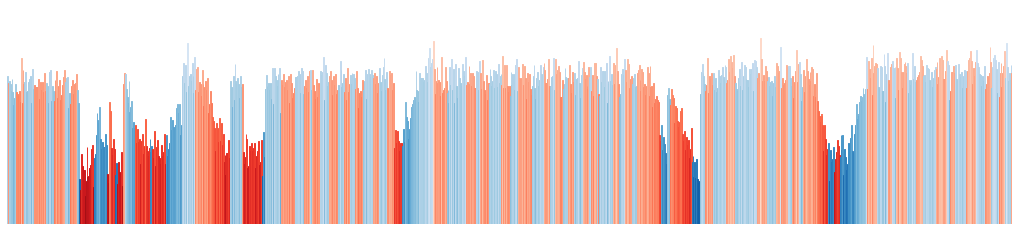

In [19]:
img_f = fnames[5]
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

In [20]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}' # converts from image to mask file name

In [21]:
get_y_fn(img_f)

PosixPath('data/train_images/rainbow_fill/train/masks/well_774.png')

We need a custom mask function as fastai merges colours

see https://forums.fast.ai/t/u-net-rgb-masks-values-convertion-in-fast-ai/50672/3

In [22]:
def get_unique_colours(img_name):
    im = pil_image.open(img_name)
    by_color = defaultdict(int)
    for pixel in im.getdata():
        by_color[pixel] += 1
    return by_color

In [23]:
rain_lbl_3=path_lbl/'well_3.png'

In [24]:
get_unique_colours(rain_lbl_3)

defaultdict(int,
            {(153, 102, 51, 255): 133547,
             (255, 255, 0, 255): 31132,
             (255, 0, 0, 255): 32963,
             (0, 0, 255, 255): 43690,
             (0, 128, 0, 255): 20468})

In [25]:
lbl_names[4]

PosixPath('data/train_images/rainbow_fill/train/masks/well_51.png')

In [26]:
get_unique_colours(lbl_names[4])

defaultdict(int,
            {(153, 102, 51, 255): 116409,
             (255, 0, 0, 255): 67168,
             (0, 128, 0, 255): 16370,
             (0, 0, 255, 255): 34262,
             (255, 255, 0, 255): 27591})

In [27]:
# create list of RGB values in order of idx value to replace with, i.e. 0: [0,0,0], 1: [255,0,0]
facies_rgb_list = [
    [153, 102, 51],
    [0, 0, 255],
    [0, 128, 0],
    [255, 0, 0],
    [255, 255, 0]]

In [28]:
def convert_mask(old_mask, rgb_list):
    new_mask = torch.zeros((old_mask.shape[-2],old_mask.shape[-1]))
    for idx, rgb in enumerate(rgb_list):
        # create a bytemask for pixels = rgb value to be replaced
        print(f'old: {old_mask.data.shape}, mask.permute: {old_mask.data.view((3,-1)).permute(1,0).shape}  mask: {old_mask.data.view((3,-1)).shape}, rgb: {tensor(rgb).shape}')
        rgb_mask = torch.sum(old_mask.data.view((3,-1)).permute(1,0) == tensor(rgb),dim=1)==3 
        # fill in pixels with new idx value
        new_mask.masked_fill_(rgb_mask.view(new_mask.shape), tensor(idx)) 
    return ImageSegment(new_mask.unsqueeze(0))

def open_mask_converted(fn:PathOrStr, div=False, convert_mode='RGB', after_open:Callable=None, rgb_list=facies_rgb_list)->ImageSegment:
    "Return `ImageSegment` object create from mask in file `fn`. If `div`, divides pixel values by 255."
    return convert_mask(open_image(fn, div=div, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open), rgb_list)

need to override SegmentationLabelList to use unique color masks

In [29]:
class SegmentationLabelList(ImageList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def open(self, fn): return open_mask_converted(fn)
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)

class SegmentationItemList(ImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

In [30]:
mask = open_mask_converted(get_y_fn(img_f), convert_mode='RGB', div=False)

old: torch.Size([3, 238, 1100]), mask.permute: torch.Size([261800, 3])  mask: torch.Size([3, 261800]), rgb: torch.Size([3])
old: torch.Size([3, 238, 1100]), mask.permute: torch.Size([261800, 3])  mask: torch.Size([3, 261800]), rgb: torch.Size([3])
old: torch.Size([3, 238, 1100]), mask.permute: torch.Size([261800, 3])  mask: torch.Size([3, 261800]), rgb: torch.Size([3])
old: torch.Size([3, 238, 1100]), mask.permute: torch.Size([261800, 3])  mask: torch.Size([3, 261800]), rgb: torch.Size([3])
old: torch.Size([3, 238, 1100]), mask.permute: torch.Size([261800, 3])  mask: torch.Size([3, 261800]), rgb: torch.Size([3])


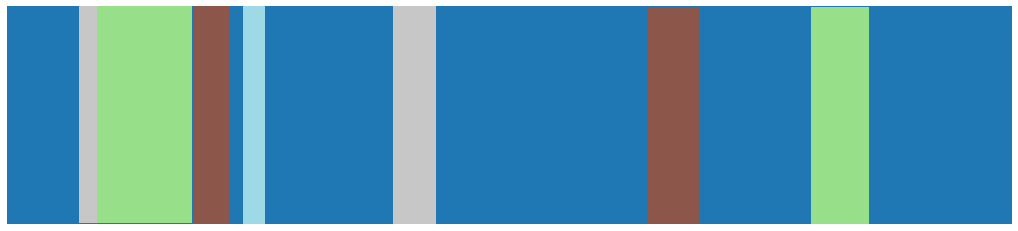

In [31]:
#mask = open_mask(get_y_fn(img_f)) # fastai shows masks with distinct colors 
# or open_mask(get_y_fn(img_f))  # mask reads file as (bs,x,y) so bs=1 here
# mask also assigns ints to floats >

#Return ImageSegment object create from mask in file fn. If div, divides pixel values by 255.
mask.show(figsize=(18,4), alpha=1)

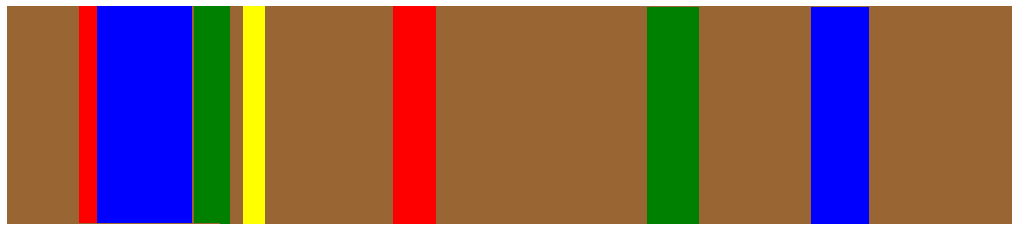

In [32]:
img_m = get_y_fn(img_f)
img = open_image(img_m)
img.show(figsize=(18,4))

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [33]:
codes = array(['None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'])

In [34]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 238, 1100]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [35]:
gr_size = np.array(img_gr.shape[1:])
gr_size,img_gr.data

(array([ 217, 1004]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.6863, 0.9882, 0.6588,  ..., 0.7020, 0.6627, 0.9882],
          [0.6863, 0.9882, 0.6588,  ..., 0.7020, 0.6627, 0.9882],
          [0.6863, 0.9882, 0.6588,  ..., 0.7020, 0.6627, 0.9882]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8196, 0.5961, 0.8078,  ..., 0.8275, 0.8118, 0.6549],
          [0.8196, 0.5961, 0.8078,  ..., 0.8275, 0.8118, 0.6549],
          [0.8196, 0.5961, 0.8078,  ..., 0.8275, 0.8118, 0.6549]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000,

<pre>
Need data layout:
    data/
        images/
        labels/ #masks - for camvid same name as image but with _P postfix (before .png)
        codes.txt #text with each label on sep line
</pre>

<pre>
camvid test code

def _check_data(data, t, v):
    assert len(data.train_ds)==t
    assert len(data.valid_ds)==v
    _ = data.train_ds[0]

camvid = untar_data(URLs.CAMVID_TINY)
test_path_lbl = camvid/'labels'
test_path_img = camvid/'images'
test_codes = np.loadtxt(camvid/'codes.txt', dtype=str)
test_get_y_fn = lambda x: test_path_lbl/f'{x.stem}_P{x.suffix}'
test_data = (SegmentationItemList.from_folder(test_path_img)
            .split_by_rand_pct()
            .label_from_func(test_get_y_fn, classes=test_codes)
            .transform(get_transforms(), tfm_y=True)
            .databunch())
_check_data(test_data, 80, 20)
</pre>

## Datasets

In [36]:
bs = 16
#size=src_size//2
#squish to square
size=(tgt_height, tgt_height)

In [37]:
tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=0., max_zoom=1.0, max_lighting=0.2, max_warp=0., p_affine=0., p_lighting=0.75)

In [38]:
src = (SegmentationItemList.from_folder(path_img)
       #.split_by_fname_file('val_20pct.csv')
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [39]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [40]:
data.train_ds.x[0].shape

torch.Size([3, 217, 1004])

In [41]:
data.train_ds.y[0].shape

torch.Size([1, 238, 1100])

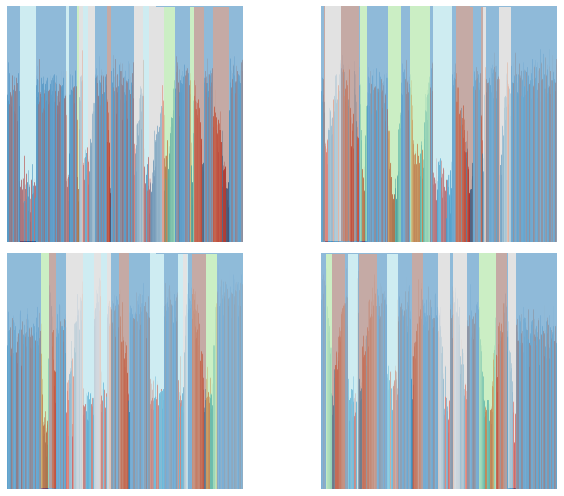

In [42]:
data.show_batch(2, figsize=(10,7))

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [43]:
def dice_loss(input, target):
    # pdb.set_trace()
    smooth = 1.
    
    input = input.sigmoid()
    input = input[:,1,None]
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()    

    return (1 - ((2. * intersection + smooth).float() / 
                 (iflat.sum() + tflat.sum() +smooth)).float())

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat()
    return bce_loss(pred,targ) + dice_loss(pred,targ)

In [44]:
def dice(input, target):
    smooth=.001
    input=input[:,1,:,:].contiguous().view(-1).float().cuda()
    target=target.view(-1).float().cuda()
    return(1-2*(input*target).sum()/(input.sum()+target.sum()+smooth))

In [45]:
#see github/daveluo/zanzibar-aerial-mapping
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
    # pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [46]:
metrics = [dice_loss, acc_thresh, dice]

In [64]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = 6

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [47]:
@dataclass
class DebugCB(LearnerCallback):
    def __init__(self, learn:Learner, clip:float = 0.):
        super().__init__(learn)
        print('DebugCB.init')

    def on_batch_begin(self, **kwargs):
        print('on_batch_begin')
    '''
    def on_backward_end(self, **kwargs):
        print('on_backward_end')
        #if self.clip: nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)
    def on_step_end(self, **kwargs):
        print('on_step_end')
    def on_batch_end(self, **kwargs):
        print('on_batch_end')
    '''
    def on_epoch_end(self, **kwargs):
        print('on_epoch_end')
    def on_train_end(self, **kwargs):
        print('on_train_end')


In [65]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, callback_fns=[partial(DebugCB)]).to_fp16()

In [66]:
#function: batch wrapped by transfroms
b=learn.data.train_dl.__iter__

In [67]:
type(learn.data.train_ds)

fastai.data_block.LabelList

In [68]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 functools.partial(<class '__main__.DebugCB'>)]

In [69]:
#learn.loss_func=dice
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [70]:

learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [71]:
learn.lr_find()

DebugCB.init


on_epoch_end
on_epoch_end
on_train_end
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: x and y must have same first dimension, but have shapes (0,) and (42,)

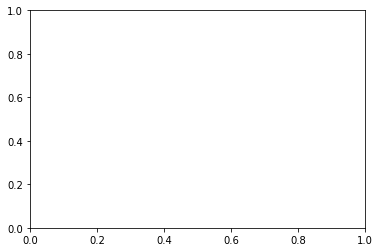

In [72]:
learn.recorder.plot()

In [ ]:
lr=1e-4

In [57]:
learn.fit_one_cycle(5, slice(lr))

DebugCB.init


epoch,train_loss,valid_loss,accuracy,time


>>accuracy input: torch.Size([16, 5, 256, 256]), targs: torch.Size([16, 1, 256, 256])
<<accuracy input: torch.Size([16, 1280]), targs: torch.Size([16, 65536])
on_train_end


RuntimeError: The size of tensor a (1280) must match the size of tensor b (65536) at non-singleton dimension 1

In [ ]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [ ]:
# Fit one cycle of 12 epochs
lr = 1e-3
learn.fit_one_cycle(12, slice(lr/30, lr))

In [ ]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [ ]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [ ]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

In [ ]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

In [ ]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

In [ ]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

In [ ]:
# Generate rle encodings (images are first converted to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [ ]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv', index=False)